<a href="https://colab.research.google.com/github/encoras/Artificial-Intelligence-Group/blob/master/Feature_selection_using_Boruta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Feature selection using Boruta**

In [76]:
# Code is adopted from the video
# https://youtu.be/_5t8ZtRybT8



import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.metrics import accuracy_score
RAND=123

In [77]:
# import some data to play with
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data

Y = breast_cancer.target
feature_names=breast_cancer.feature_names

In [78]:
#Define x and normalize values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

##Split data into train and test to verify accuracy after fitting the model. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=RAND)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
###########################################################################

Create shadow features – random features and shuffle values in columns
Train Random Forest / XGBoost and calculate feature importance via mean decrease impurity
Check if real features have higher importance compared to shadow features 
Repeat this for every iteration
If original feature performed better, then mark it as important 

In [79]:
!pip install boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [80]:
# Define RandomForest classifier to be used by Boruta
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=RAND)
rfr.fit(X_train, y_train)
y_pred=rfr.predict(X_test)>0.5
scores_RFR=accuracy_score(y_test,y_pred)
print('RFR_ALL_features = ', scores_RFR)

RFR_ALL_features =  0.986013986013986


In [81]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=RAND)
rfc.fit(X_train, y_train)
y_pred=rfc.predict(X_test)
scores_RFC=accuracy_score(y_test,y_pred)
print('RFC_ALL_features = ', scores_RFC)

RFC_ALL_features =  0.993006993006993


In [82]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(random_state=RAND)
etc.fit(X_train, y_train)
y_pred=etc.predict(X_test)
scores_ETC=accuracy_score(y_test,y_pred)
print('ETC_ALL_features = ', scores_RFC)

ETC_ALL_features =  0.993006993006993


In [83]:
from boruta import BorutaPy

# define Boruta feature selection method: rfr, rfc, etc
feat_selector = BorutaPy(rfc, n_estimators='auto', verbose=0, random_state=RAND)

# find all relevant features
feat_selector.fit(X_train, y_train)


# check selected features
print(feat_selector.support_)  #Should we accept the feature

# check ranking of features
print(feat_selector.ranking_) #Rank 1 is the best

[ True  True  True  True False  True  True  True False False  True False
  True  True False False  True False False False  True  True  True  True
  True  True  True  True  True  True]
[1 1 1 1 2 1 1 1 4 6 1 8 1 1 6 3 1 2 7 3 1 1 1 1 1 1 1 1 1 1]


In [84]:
# call transform() on X to filter it down to selected features
X_train_filtered = feat_selector.transform(X_train)  #Apply feature selection and return transformed data
X_test_filtered = feat_selector.transform(X_test)
"""
Review the features
"""
# zip feature names, ranks, and decisions 
feature_ranks = list(zip(feature_names, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# print the results
for feat in feature_ranks:
    print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: mean radius                    Rank: 1,  Keep: True
Feature: mean texture                   Rank: 1,  Keep: True
Feature: mean perimeter                 Rank: 1,  Keep: True
Feature: mean area                      Rank: 1,  Keep: True
Feature: mean smoothness                Rank: 2,  Keep: False
Feature: mean compactness               Rank: 1,  Keep: True
Feature: mean concavity                 Rank: 1,  Keep: True
Feature: mean concave points            Rank: 1,  Keep: True
Feature: mean symmetry                  Rank: 4,  Keep: False
Feature: mean fractal dimension         Rank: 6,  Keep: False
Feature: radius error                   Rank: 1,  Keep: True
Feature: texture error                  Rank: 8,  Keep: False
Feature: perimeter error                Rank: 1,  Keep: True
Feature: area error                     Rank: 1,  Keep: True
Feature: smoothness error               Rank: 6,  Keep: False
Feature: compactness error              Rank: 3,  Keep: False
Feature: concavity

**Now use the subset of features to fit  model on training data**

RFR_ALL_features =  0.986013986013986  vs RFR_filtered =  0.986013986013986 Is better?  False
RFC_ALL_features =  0.993006993006993  vs RFC_filtered =  0.993006993006993 Is better?  False
ETC_ALL_features =  0.986013986013986  vs ETC_filtered =  0.993006993006993 Is better?  True


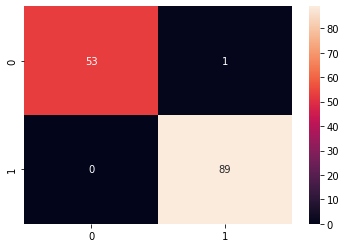

In [86]:
rfr.fit(X_train_filtered, y_train)
y_pred=rfr.predict(X_test_filtered)>0.5
scores_RFR1=accuracy_score(y_test,y_pred)
print('RFR_ALL_features = ', scores_RFR, ' vs RFR_filtered = ', scores_RFR1, 'Is better? ', scores_RFR<scores_RFR1)
#######################################

rfc.fit(X_train_filtered, y_train)
y_pred=rfc.predict(X_test_filtered)
scores_RFC1=accuracy_score(y_test,y_pred)
print('RFC_ALL_features = ', scores_RFC, ' vs RFC_filtered = ', scores_RFC1, 'Is better? ', scores_RFC<scores_RFC1)
#######################################

etc.fit(X_train_filtered, y_train)
y_pred=etc.predict(X_test_filtered)
scores_ETC1=accuracy_score(y_test,y_pred)
print('ETC_ALL_features = ', scores_ETC, ' vs ETC_filtered = ', scores_ETC1, 'Is better? ', scores_ETC<scores_ETC1)

#Print overall accuracy


#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
#print(cm)
sns.heatmap(cm, annot=True)

#######################################################




